In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [2]:
from mira.openai import OpenAIClient
from mira.sources.sympy_ode.llm_util import execute_template_model_from_sympy_odes, image_file_to_odes_str
client = OpenAIClient(api_key=os.getenv("OPENAI_API_KEY"))

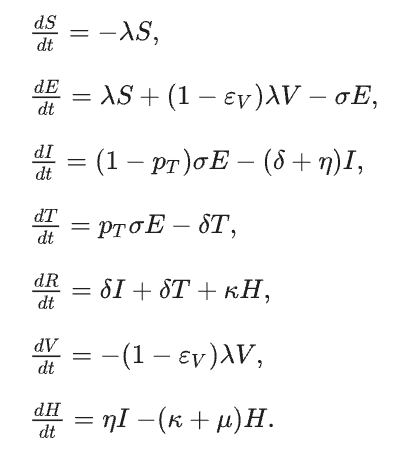

In [3]:
# Extract ODEs from image
from IPython.display import Image
Image('/Users/kovacs.f/Desktop/kep.png')

In [4]:
ode_str = image_file_to_odes_str('/Users/kovacs.f/Desktop/kep.png', client=client)
print(ode_str)
# Note that the LLM sometimes misses to define one of the parameters. When this happens, a human-in-the-loop can quickly edit the output

INFO: [2025-07-31 16:02:51] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


import sympy

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
s, e, i, t_, r, v, h = sympy.symbols("s e i t r v h", cls=sympy.Function)

# Define the parameters
lambda_, epsilon_v, p_t, delta, eta, kappa, mu = sympy.symbols("lambda epsilon_v p_t delta eta kappa mu")

odes = [
    sympy.Eq(s(t).diff(t), - lambda_ * s(t)),
    sympy.Eq(e(t).diff(t), lambda_ * s(t) + (1 - epsilon_v) * lambda_ * v(t) - sigma * e(t)),
    sympy.Eq(i(t).diff(t), (1 - p_t) * sigma * e(t) - (delta + eta) * i(t)),
    sympy.Eq(t_.diff(t), p_t * sigma * e(t) - delta * t_),
    sympy.Eq(r(t).diff(t), delta * i(t) + delta * t_ + kappa * h(t)),
    sympy.Eq(v(t).diff(t), -(1 - epsilon_v) * lambda_ * v(t)),
    sympy.Eq(h(t).diff(t), eta * i(t) - (kappa + mu) * h(t))
]


In [5]:
# Cleaned version of string above, uncomment to use it
ode_str = """import sympy

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, E, I, T, R, V, H = sympy.symbols("S E I T R V H", cls=sympy.Function)

# Define the parameters
lambda_, epsilon_v, p_T, delta, eta, kappa, mu, sigma = sympy.symbols("lambda_ epsilon_v p_T delta eta kappa mu sigma")

odes = [
    sympy.Eq(S(t).diff(t), - lambda_ * S(t)),
    sympy.Eq(E(t).diff(t), lambda_ * S(t) + (1 - epsilon_v) * lambda_ * V(t) - sigma * E(t)),
    sympy.Eq(I(t).diff(t), (1 - p_T) * sigma * E(t) - (delta + eta) * I(t)),
    sympy.Eq(T(t).diff(t), p_T * sigma * E(t) - delta * T(t)),
    sympy.Eq(R(t).diff(t), delta * I(t) + delta * T(t) + kappa * H(t)),
    sympy.Eq(V(t).diff(t), - (1 - epsilon_v) * lambda_ * V(t)),
    sympy.Eq(H(t).diff(t), eta * I(t) - (kappa + mu) * H(t))
]"""

In [6]:
# Now get a template model from the extracted ODE str and send the ODE system in for attempting to ground each compartment
tm = execute_template_model_from_sympy_odes(ode_str=ode_str, attempt_grounding=True, client=client)

INFO: [2025-07-31 16:02:57] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [7]:
# Check the concepts
print('concept name\tidentifiers\tcontext')
for concept in tm.get_concepts_map().values():
    print(f'{concept.name}\t{concept.identifiers}\t{concept.context}')

concept name	identifiers	context
H	{'ido': '0000511'}	{'hospitalization': 'ncit:C25179', 'species': 'ncbitaxon:9606'}
R	{'ido': '0000592'}	{'outcome': 'recovered', 'species': 'ncbitaxon:9606'}
I	{'ido': '0000511'}	{'stage': 'infected', 'severity': 'variable', 'species': 'ncbitaxon:9606'}
S	{'ido': '0000514'}	{'status': 'susceptible', 'species': 'ncbitaxon:9606'}
E	{'apollosv': '00000154'}	{'stage': 'exposed', 'species': 'ncbitaxon:9606'}
V	{'ido': '0000514'}	{'status': 'vaccinated', 'species': 'ncbitaxon:9606'}
T	{'ido': '0000511'}	{'treatment': 'isolated', 'species': 'ncbitaxon:9606'}


In [8]:
from mira.modeling import Model
from mira.modeling.ode import OdeModel
om = OdeModel(Model(tm), initialized=True)
om.get_interpretable_kinetics()

Matrix([
[Derivative(H, t), =,                                                  -H*(kappa + mu) + I*eta],
[Derivative(I, t), =,                                      E*sigma*(1 - p_T) - I*(delta + eta)],
[Derivative(R, t), =,                                              H*kappa + I*delta + T*delta],
[Derivative(S, t), =,                                                               -S*lambda_],
[Derivative(E, t), =, -E*p_T*sigma - E*sigma*(1 - p_T) + S*lambda_ + V*lambda_*(1 - epsilon_v)],
[Derivative(V, t), =,                                               -V*lambda_*(1 - epsilon_v)],
[Derivative(T, t), =,                                                    E*p_T*sigma - T*delta]])

## Further models

In [9]:
from mira.sources.sympy_ode.llm_util import (
    execute_template_model_from_sympy_odes,
    image_file_to_odes_str,
)
from IPython.display import Image
from collections import defaultdict
import pygraphviz


In [10]:
original_ode_str_biomd_955 = """
# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, I, D, A, R, T, H, E = sympy.symbols("S I D A R T H E", cls=sympy.Function)

# Define the parameters
alpha, beta, gamma, delta, epsilon, zeta, lambda_, eta, rho, theta, mu, nu, xi, sigma, tau, kappa, lambda_ = sympy.symbols("alpha beta gamma delta epsilon zeta lambda eta rho theta mu nu xi sigma tau kappa lambda_")

odes = [
    sympy.Eq(S(t).diff(t), - S(t) * (alpha * I(t) + beta * D(t) + gamma * A(t) + delta * R(t))),
    sympy.Eq(I(t).diff(t), S(t) * (alpha * I(t) + beta * D(t) + gamma * A(t) + delta * R(t)) - (epsilon + zeta + lambda_) * I(t)),
    sympy.Eq(D(t).diff(t), epsilon * I(t) - (eta + rho) * D(t)),
    sympy.Eq(A(t).diff(t), zeta * I(t) - (theta + mu + kappa) * A(t)),
    sympy.Eq(R(t).diff(t), eta * D(t) + theta * A(t) - (nu + xi) * R(t)),
    sympy.Eq(T(t).diff(t), mu * A(t) + nu * R(t) - (sigma + tau) * T(t)),
    sympy.Eq(H(t).diff(t), lambda_ * I(t) + rho * D(t) + kappa * A(t) + xi * R(t) + sigma * T(t)),
    sympy.Eq(E(t).diff(t), tau * T(t))
]
"""
tm_955 = execute_template_model_from_sympy_odes(ode_str=original_ode_str_biomd_955, attempt_grounding=True, client=client)

print('concept name\tidentifiers\tcontext')
for concept in tm_955.get_concepts_map().values():
    print(f'{concept.name}\t{concept.identifiers}\t{concept.context}')

om_955 = OdeModel(Model(tm_955), initialized=True)
om_955.get_interpretable_kinetics()

INFO: [2025-07-31 16:03:08] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


concept name	identifiers	context
H	{'ido': '0000511'}	{'hospitalization': 'ncit:C25179'}
I	{'ido': '0000511'}	{'disease_severity': 'ncit:C25269'}
T	{'ido': '0000592'}	{'treatment': 'ncit:C25179'}
R	{'ido': '0000592'}	{'recovered': 'ncit:C25273'}
D	{'ido': '0000511'}	{'disease_severity': 'ncit:C25376'}
A	{'ido': '0000511'}	{'disease_severity': 'ncit:C3833'}
E	{'apollosv': '00000154'}	{'exposed': 'ncit:C24467'}
S	{'ido': '0000514'}	{'susceptible': 'ncit:C25270'}


Matrix([
[Derivative(I, t), =, -I*(epsilon + lambda_ + zeta) + S*(A*gamma + D*beta + I*alpha + R*delta)],
[Derivative(H, t), =,                             A*kappa + D*rho + I*lambda_ + R*xi + T*sigma],
[Derivative(T, t), =,                                            A*mu + R*nu - T*(sigma + tau)],
[Derivative(R, t), =,                                            A*theta + D*eta - R*(nu + xi)],
[Derivative(D, t), =,                                               -D*eta - D*rho + I*epsilon],
[Derivative(A, t), =,                                         -A*(kappa + mu + theta) + I*zeta],
[Derivative(E, t), =,                                                                    T*tau],
[Derivative(S, t), =,                                -S*(A*gamma + D*beta + I*alpha + R*delta)]])

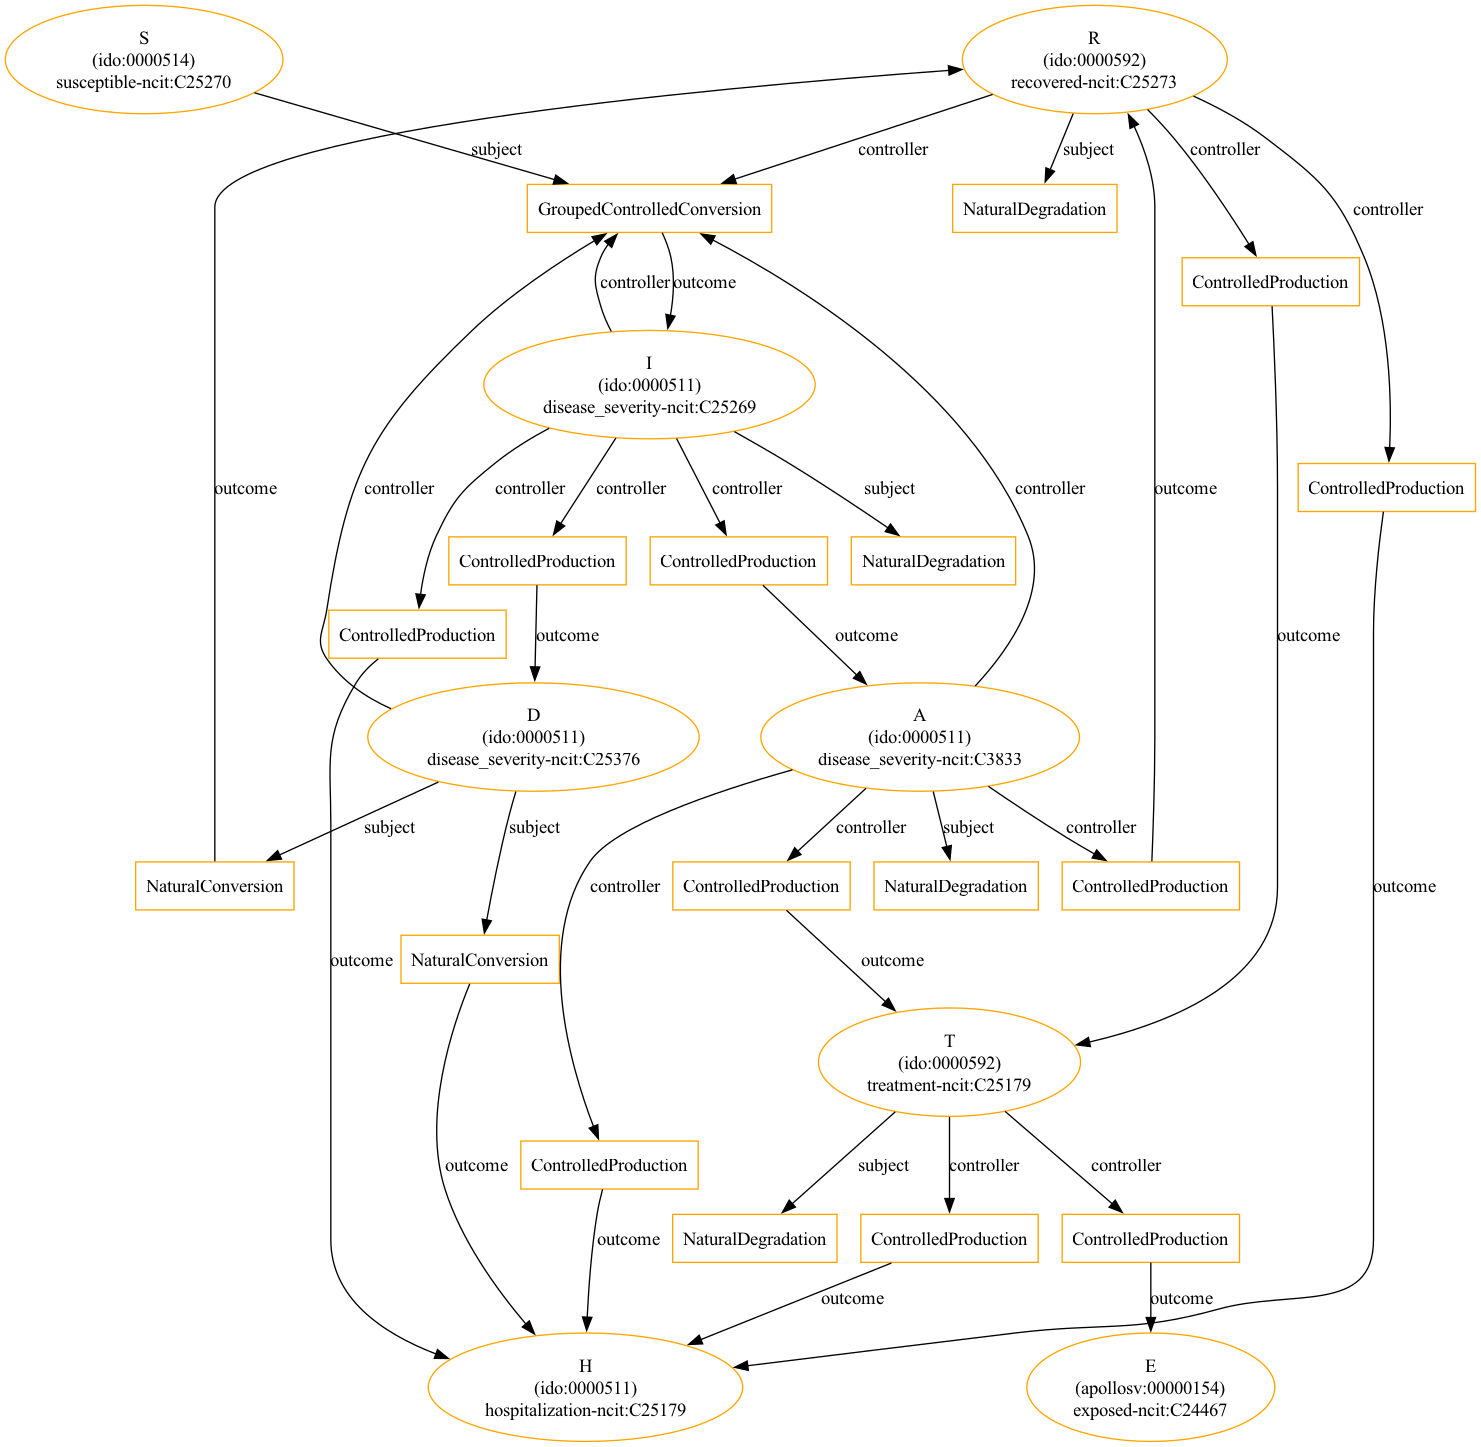

In [11]:
tm_955.draw_jupyter()